In [2]:
from utils.process_data import get_data

# Load data
ingredient_df = get_data()

# Define the mapping dictionary
rating_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}

# Apply the mapping to the 'Animal Welfare Rating' column
x = [rating_to_int[val] for val in ingredient_df['Animal Welfare Rating'].values]

print(x)
print(x[0])
print(type(x))


Successfully read 137 lines from the file. Loaded 136 ingredients.
[1, 1, 5, 1, 1, 1, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1, 1, 5, 1, 5, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 5, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1, 1, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
1
<class 'list'>


Estimated number of people not eating the ingredient: 251 out of 1000
Total expected consumption: 9309.15 grams
Total expected food waste for 1000 people: 390690.85 grams
Mean of the normal distribution samples: 9.30914660535424
Standard deviation of the normal distribution samples: 8.96575466666406


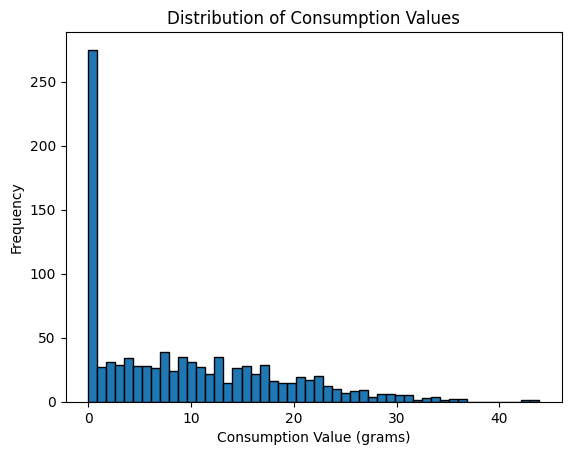

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Given values
mean = 7.59490565
standard_deviation = 11.22572649
threshold = 0  # Define the threshold below which people won't eat
value_in_meal_plan = 400
num_people = 1000  # Example number of people

# Generate random values from a normal distribution for each person
consumption_values = np.random.normal(loc=mean, scale=standard_deviation, size=num_people)

# Replace negative values with zero for realistic consumption values
consumption_values = np.where(consumption_values < 0, 0, consumption_values)

# Calculate the number of people not eating the ingredient
num_not_eating = np.sum(consumption_values == 0)

# Calculate the total expected consumption
total_expected_consumption = np.sum(consumption_values)

# Calculate the expected food waste
total_food_waste = value_in_meal_plan * num_people - total_expected_consumption

# Print results
print(f"Estimated number of people not eating the ingredient: {num_not_eating} out of {num_people}")
print(f"Total expected consumption: {total_expected_consumption:.2f} grams")
print(f"Total expected food waste for {num_people} people: {total_food_waste:.2f} grams")

# Optional: Print mean and standard deviation of the samples
print("Mean of the normal distribution samples:", np.mean(consumption_values))
print("Standard deviation of the normal distribution samples:", np.std(consumption_values))

# Visualize the distribution
plt.hist(consumption_values, bins=50, edgecolor='black')
plt.title('Distribution of Consumption Values')
plt.xlabel('Consumption Value (grams)')
plt.ylabel('Frequency')
plt.show()


In [11]:
from gymnasium.envs.registration import register
import gymnasium as gym

register(
    id='SchoolMealSelection-v1',
    entry_point='models.envs.env_working:SchoolMealSelection',
    max_episode_steps=10,  # Allow multiple steps per episode, adjust as needed
)

# Get the environment specification for 'SchoolMealSelection-v1'
env_spec = gym.envs.registry.get('SchoolMealSelection-v1')

if env_spec:
    print(f"\nEnvironment ID: {env_spec.id}")
    print(f"Entry Point: {env_spec.entry_point}")
    print(f"Max Episode Steps: {env_spec.max_episode_steps}")
else:
    print("Environment 'SchoolMealSelection-v1' is not registered.")



Environment ID: SchoolMealSelection-v1
Entry Point: models.envs.env_working:SchoolMealSelection
Max Episode Steps: 10


/home/laurie2905/anaconda3/envs/masterEnv/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment SchoolMealSelection-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [ ]:
max(1000 // 8, 1)

In [3]:
ingredient_group_target_ranges = {
    'fruit': 1, # 1 fruit a day per meal
    'veg': 1, # 1 veg per day per meal
    'non_processed_protein': 1, # Portion of non processed protein has to be provided accept if a portion of processed protein is provided. This current env is one day meal selection.
    'processed_protein': 1, # Processed protein, see above ^
    'carbs': 1, # Starchy food , a portion of this should be provided every day
    'dairy': 1, # Dairy, a portion of this should be provided every day
    'bread': 1, # Bread should be provided as well as a portion of starchy food
    'confectionary': 0 # No confectionary should be provided
}
print(len(ingredient_group_target_ranges.keys()))
food_group_counts = {k: 0 for k in ingredient_group_target_ranges.keys()}

8


In [2]:
import unittest

# Assuming the function and necessary variables are defined in a module named 'reward_module'
from models.reward.reward import group_count_reward

class TestGroupCountReward(unittest.TestCase):

    def setUp(self):
        # Setting up default values for the tests
        self.ingredient_group_portion = {
            'non_processed_protein': 300,
            'processed_protein': 200,
            'confectionary': 150,
            'vegetables': 500,
            'fruits': 300
        }
        
        self.ingredient_group_count = {
            'non_processed_protein': 3,
            'processed_protein': 2,
            'confectionary': 1,
            'vegetables': 5,
            'fruits': 3
        }
        
        self.ingredient_group_portion_targets = {
            'non_processed_protein': (100, 150),
            'processed_protein': (80, 120),
            'confectionary': (50, 60),
            'vegetables': (80, 100),
            'fruits': (90, 110)
        }
        
        self.ingredient_group_count_targets = {
            'non_processed_protein': 3,
            'processed_protein': 2,
            'confectionary': 1,
            'vegetables': 5,
            'fruits': 3
        }

    def test_all_targets_met(self):
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': 50,
            'processed_protein': 50,
            'confectionary': 100,
            'vegetables': 100,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertTrue(all_targets_met)
    
    def test_protein_target_not_met(self):
        self.ingredient_group_count['non_processed_protein'] = 2
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': -50,
            'processed_protein': -50,
            'confectionary': 100,
            'vegetables': 100,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)
    
    def test_protein_target_exceeded(self):
        self.ingredient_group_count['non_processed_protein'] = 4
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': -25,
            'processed_protein': -25,
            'confectionary': 100,
            'vegetables': 100,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)
    
    def test_confectionary_target_not_met(self):
        self.ingredient_group_count['confectionary'] = 0
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': 50,
            'processed_protein': 50,
            'confectionary': -100,
            'vegetables': 100,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)
    
    def test_other_group_target_not_met(self):
        self.ingredient_group_count['vegetables'] = 4
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': 50,
            'processed_protein': 50,
            'confectionary': 100,
            'vegetables': -100,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)
    
    def test_other_group_target_exceeded(self):
        self.ingredient_group_count['vegetables'] = 6
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': 50,
            'processed_protein': 50,
            'confectionary': 100,
            'vegetables': 0,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)

    def test_combination_of_targets(self):
        self.ingredient_group_count['non_processed_protein'] = 4
        self.ingredient_group_count['processed_protein'] = 3
        self.ingredient_group_count['confectionary'] = 2
        self.ingredient_group_count['vegetables'] = 4
        self.ingredient_group_count['fruits'] = 2
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': -50,
            'processed_protein': -50,
            'confectionary': -100,
            'vegetables': -100,
            'fruits': -100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)

if __name__ == '__main__':
    unittest.main()


usage: ipykernel_launcher.py [-h] [-v] [-q] [--locals] [-f] [-c] [-b]
                             [-k TESTNAMEPATTERNS]
                             [tests ...]
ipykernel_launcher.py: error: argument -f/--failfast: ignored explicit argument '/home/laurie2905/.local/share/jupyter/runtime/kernel-v2-516hmvS5eIBZeMQ.json'


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [ ]:
def estimate_line_size(file_path, num_lines=100):
    with open(file_path, 'r') as file:
        total_size = 0
        for _ in range(num_lines):
            line = file.readline()
            total_size += len(line)
    return total_size / num_lines

In [5]:
x = '{"total_reward": [-156.343358308735, 164.39291606971065, 459.5105453420927, 491.7386345411837, 486.7027207214882, 629.531726345288, 624.8748689829962, 609.2051418612091, 609.274549053864, 627.5065311490031, 651.4783495597293, 366.0438366726863, 367.60642622926116, 525.9472733112113, 399.6658285622548, 462.0437632265687, 535.8378030747051, 520.9714023969198, 329.0752218587945, 322.0292507490764, 425.6081592059508, 596.575413179323, 274.80452088108905, 343.2062373363956, 363.2472731208914, 431.2593207541729, 476.164828560191, 474.2498552781219, 489.04090260031325, 484.2937459117423, 501.6062299088636, 508.83116978975636, 519.9479539815585, 368.77669862056774, 346.51200778144107, 261.3715686230858, 152.7543500498682, 128.0086929079145, 249.6325582998246, 251.50119915179909, 105.59733234293759, 133.2600139979273, 116.43327257432043, 287.77415628078086, 295.7478357771287, 189.680863650615, 327.4345735240976, 332.5307525268445, 330.81905415351196, 240.50060443120697, 332.7399754674236, 215.42853877427675, 232.74729968706765, 84.18169295402865, -1.6902418201416936, 195.57721237171754, 152.1488605102431, 28.730951634173607, 196.87827177209158, 205.93744439882536, 139.45641069034738, 33.74544653807456, 44.73768677021067, 193.9665293131365, 44.1816525566733, 118.4930978535364, 295.3570261838287, 83.253590101564, -7.459877594572816, 217.50996870268136, 358.5749259659648, 212.63614742640408, 62.82392800922193, 149.9944757589946, 206.59175652055222, 71.36287230262687, -54.04093586751108, 123.08873976093562, -137.6181954951885, 190.02752050497878, -17.294072252488718, -45.262878532148875, 147.89838978162035, 173.6087521322941, 193.66493201127588, 194.63356500173296, -105.69570667145459, 186.14906309256645, 155.0190274106789, 25.568782834370325, -107.3361195562516, -8.60004433105695, 291.839266855605, 277.4672079091597, 95.37288399185479, -80.09510721647689, -79.17182314339601, -98.44300276074557, -115.32234184123575, -269.72461562599983, -263.26799397222703, -284.5255635484681, -290.90906258948144, -159.89371195182207, -159.50366875778883, -165.22907277762891, -151.55581155043097, -151.32637196160852, -168.95430465999993, -177.09471660748125, -201.9333738188073, -561.1973649500683, -662.3497202407568, -566.7348050459102, -663.772141193971, -673.5904957855121, -529.9932068157941, -681.5902605621145, -544.9403843300418, -555.3175261771306, -550.0345763061196, -548.4156052976846, -554.3906348071991, -567.1188052855432, -567.363822016865, -565.3824758604169, -573.1206021467224, -686.742906441912, -583.308248241432, -574.594714191556, -577.9252870291471, -570.677639073506, -547.9455335753784, -546.4233704923465, -689.7789430693537, -691.3906759192049, -674.3958454961702, -679.8398204685002, -686.1299106824026, -546.1989168039337, -534.2766709971521, -622.4345244630053, -702.8983996489364, -425.0612270626674, -797.6776363269162, -806.449286744371, -718.4125820972025, -708.3072843538597, -693.391989999637, -705.4037491548806, -709.4538238637149, -699.6224541082979, -549.5148667288945, -705.5353650311008, -695.8590487809852, -608.5501190876836, -568.520961665848, -450.9358326455206, -150.6392782507092, -464.3630401065201, -310.9791444198787, -463.21780418694027, -610.67170924671, -453.3642675969377, -705.9991100230068, -300.29959150977436, -603.65841534283, -703.3154984882847, -717.9643406842649, -609.0064838086814, -545.2084833632036, -439.8332050338015, -437.655779543668, -433.592360983193, -430.54267444998027, -427.832513579689, -423.830653492324, -471.1923708787576, -294.4366621675016, -478.95290902396664, -485.5837675658986, -513.3029537720606, -543.0627896202728, -520.082955007255, -537.7607078641654, -551.2330678634346, -552.045177596528, -547.3270511319861, -536.2387756127864, -591.540533931274, -577.0888646354201, -597.5927169945091, -543.8358307531104, -633.9438130399757, -615.8262660661557, -618.9789344444017, -612.9941103281532, -603.5589828020272, -615.7375031905327, -621.6827341578979, -747.8477673542299, -576.1316092686338, -744.1551151178622, -608.4892378076291, -709.0551302074765, -617.8798791357627, -602.121049440916, -603.2670432356496, -745.8890068384197, -743.4165763629445, -579.6685133810465, -304.2081829715521, -286.77041322340557, -182.32407129920392, -173.96819812666007, -183.560292530631, -323.8864402598825, -332.2288044417401, -326.62942658729224, -345.1620824075971, -389.08227028570906, -238.73435998596716, -228.26904188299557, -74.23164287853058, -73.41273982220793, -67.58444785215892, -73.63689304591162, -67.53518179546575, -342.03634013188383, -333.5440917320177, -46.89905446414838, -24.3796942767625, -181.1321939806625, -90.11137128628476, -344.50284678496416, -373.34684518415474, -386.12369160436094, -374.71310610741375, -501.9775098818168, -493.6450953461974, -499.5473481972515, -534.9471178625524, -513.0260587275773, -506.3274224757031, -504.93901165694, -516.9315862570703, -497.10319552410397, -513.0224017248302, -497.3842528839409, -520.5229143577442, -519.5178246632963, -533.283749874942, -520.5671391358412, -699.1696996013447, -559.8030647268333, -1591.3373273602501, -304.1056138209688, -218.51197894664176, -275.9828509765739, -247.25770617923394, -251.1929272522653, -173.12959483147597, -356.0488386263512, -255.36189785326206, -259.551059889542, 267.27880620534535, -328.10760231742944, -106.22099762479466, 22.526213383989685, 382.58715538052843, 105.4380132349487, 8.707134874975281, -74.71824633415169, 64.97053335087375, 44.01693054961041, 42.40501810612159, 64.81944086553528, -65.10574794856831, -71.84185433162372, -86.8296200901704, -30.61703593238566, -23.77173307343692, -180.30571718617654, -212.07368825579067, -236.98300765434283, -89.43513852039348, -232.28507490137594, -278.1665247982927, -29.86923484491183, -10.81305904667515, 133.3387982579352, 114.17805757751375, -7.264691195770482, -201.83656923521, 152.18084760964229, 29.442146542544194, -129.6845880174389, -3.4539567747463167, 155.78281391176085, 149.27948813351486, -128.8738071569552, 37.368321166361326, 34.82313758643964, 42.55897820057969, 24.87660607459638, 174.17850222351655, 14.746218376482531, 20.787228815878436, 270.2461385721217, -26.433994453623882, 59.59591489009557, -14.890808384790944, -111.93411318639913, -36.775393262902796, -195.60660920629908, -116.41088285485903, -48.50809343042165, -32.312717472336445, -199.1182837151705, 121.7894331283153, 191.85595747359406, 137.28944394298207, 230.43823721734339, 223.72066099760593, -294.9186989590992, -232.620627157297, 12.431213098779992, -140.71141772535628, -5.439437284933732, -22.847516708013885, -19.032916924807537, -15.082859169629742, 123.8713006481683, -185.1934869927743, -178.9406362380289, -202.5948858156491, -375.25289621552605, -458.62714192971276, -128.86962253100546, -52.19507894719335, -38.9988810261557, -22.85704943890063, -41.118851082570316, -210.72413769269673, -300.09238962316107, -202.4794118213157, -195.39320284674568, -287.8417677730322, -322.83951934128993, -363.4339801594615, -371.7435321465134, -370.5224400162697, -312.92673459500065, -468.7320914849638, -380.44277270585303, -460.1942235097289, -522.9899819776415, -522.3923016920685, -360.04552698880434, -182.50899254828693, -165.72809336930516, -168.5701911270619, -179.92712732255455, -176.99167580753556, -165.47469763129953, -179.26875042319296, -134.9391277757287, -203.52041882531097, -289.17979289263485, -163.1869346752763, -288.33614181548364, -151.18756683766838, -312.9572760790586, -454.0410333558916, -296.85600296854966, -580.521641830802, -436.8916120123863, -445.2510319513083, -464.695267524831, -486.91704720817506, -476.246428206563, -457.7410085827112, -479.06213593781, -325.5738102614879, -494.3365695416928, -494.82303996086125, -518.8202745705843, -513.777059829235, -522.9672272056341, -526.4754500240088, -516.3422625213861, -503.8040235340595, -545.6410836784169, -530.1489282265306, -523.2180465579033, -520.1945883944632, -359.5954304158688, -288.9712974768411, -490.09390050188784, -524.9536878178517, -535.8566254968443, -578.8859523970011, -578.6286250784372, -592.5110967691367, -611.5983866459999, -587.9435668168899, -573.2803607615022, -534.1921420369422, -536.0861419232685, -530.9472469776993, -540.4500304226888, -521.2214645741631, -542.6121281585779, -346.3794625268365, -480.7067110726657, -213.42574212484527, -153.18887567035546, -169.77578540132072, -353.907905526751, -383.90333847479275, -390.8784007709597, -372.67840706744533, -274.43876668954886, -223.55783559630316, -187.88039723386368, -201.01717204203214, -217.93909342934688, -192.8318924625715, -202.8398655792077, -189.36341601957872, -299.44000029668206, -377.8806282756229, -432.0429609941163, -426.9980623112836, -307.9783500362809, -307.25943432642765, -308.47889997257533, -340.50628238810845, -491.266587464946, -490.67473879649, -241.92058637632687, -491.0604712982351, -389.49194935752706, -649.2571744425843, -650.0876082138778, -495.0730681618365, -496.7124632158472, -499.24916811442625, -503.36515079277257, -510.0290834657537, -530.1242691538916, -532.3868309767606, -525.5244513382825, -517.455024900722, -519.6145060840684, -527.5675030487746, -526.3197405595022, -524.833010929792, -515.4788005611549, -514.1306824250303, -520.3190767215256, -517.6939989588379, -519.8413571445892, -504.04252510842565, -518.570595640565, -658.8387946101246, -674.6564170162814, -619.3746722927938, -707.2396409201048, -703.6008315306079, -698.2467753712709, -720.0029758773259, -724.1685272784417, -727.1146417660153, -567.0835522054695, -694.533465358025, -693.2811872259402, -686.170576780724, -688.0020379173259, -686.8230847592155, -523.43640698685, -427.75106423987694, -430.76683400763824, -428.54064926399536, -433.54376811279616, -435.3574734617645, -534.1251931120332, -431.684928374427, -424.4687021840985, -418.65721731676416, -426.35690391554186, -413.4649042178566, -402.6363434244568, -371.2992622916276, -631.9309601779406, -474.2727112076555, -472.34837873497355, -374.2534336769954, -634.6920970774567, -619.6789668313538, -519.4034482926752, -276.48732081837954, -126.96088282801207, -280.5432751480489, -69.5526611100262, 89.87800506426646, -53.68041800932339, 83.57667682661366, -67.16950534687682, -63.124244968158465, -211.92189994261912, -61.84700095461058, -205.38054328964404, -122.08488840032373, 45.63403373967856, -301.10011519778527, -286.7437630160525, -27.398568266316616, -140.88066886669333, -73.24607255688245, -180.63716505876118, -162.783263143807, -161.22358850380715, -11.54553712895445, -16.86401923587853, -16.675993075876775, -169.72783512166075, -16.869979172854997, -13.881185820608678, -2.285871012120836, -3.0515865813785723, -3.294238356857889, -19.46593525102675, -20.151404353886235, -20.523525217085435, -166.94047787180483, -17.41301617315351, -18.68931191256577, -173.16885608723697, -19.78449284723338, -171.90261272183, -173.4806449472004, -175.82396505764058, -177.54738534679944, -174.9642418264442, -177.36007701596554, -174.1658636509472, -176.68779627671773, -174.0455740629726, -169.8039393036657, -169.56740213623578, -171.91880712947187, -318.4510973147148, -312.1081856793755, -312.34178056931427, -316.17522309935026, -314.9416757843488, -164.14482458895378, -166.61700795656378, -167.4065691626662, -167.91350291138826, -168.0715348935717, -93.2588642466658, -169.06635551816157, -182.2101469654434, -165.2503501451605, -166.09263664847543, -294.7370563835993, -189.6197475780143, -128.5744578082456, -443.0476089594296, -139.08081169094578, -185.74190689515018, -159.52153380404843, -140.03445990191466, -294.14761412538274, -141.55932719673655, -193.18972265556147, -197.28259682230345, -141.60751455345815, -145.4897684174, -180.06508884892486, -324.66100589178194, -320.41017993550435, -301.6235318842034, -483.36255383857406, -504.16576303809757, -616.247333085492, -600.6360998422155, -292.4018331448408, -494.3130560478366, -505.28881150953777, -553.6388581949037, -313.07128897126137, -390.3073171531906, -239.09480593419948, -341.84004242082443, -283.43029699098315, -134.3027864212729, -211.0947237883135, -282.063489871781, -380.6609743105775, -438.08097035699217, -422.67505993112144, -394.46086889826853, -162.14516635168349, -276.196587339857, -312.11703911670173, -302.8292992466099, -280.307233928234, -434.89392270792433, -261.96349009065574, -375.3461790088563, -420.37694920725346, -434.518790400705, -446.9154346105658, -420.20936627861425, -254.72903336885685, -548.078301714106, -251.88362426335613, -562.9737771543596, -239.67418372587758, -126.94263497839368, -304.1672225753094, -428.39837772238695, -206.71216007820018, -308.7745727870846, -491.6110965712167, -333.33903783539614, -58.774170704822346, -258.3369953889214, -400.600725592592, -122.15912655034408, -127.61197039253388, -116.71022345746248, -152.3946730049637, -151.68574013450495, -142.88590164469866, -289.9372512662209, -261.56908879857195, -87.52486615818616, -126.7539884822226, -193.625694044, -293.8838673682743, -337.9118418729165, -232.4617097646743, -244.44541388100942, -331.9284618643951, -146.3422270276211, -191.24982571364535, 3.7721826798236293, -68.88819679277638, -16.767178587309715, -23.509069886125346, -77.36070461853876, -97.90748430514248, -86.7398556679611, -101.87282111904427, 187.5672455214771, 28.32818937698532, 31.22820892851955, -110.11249195066127, 22.57330945906385, -103.28309984862643, -113.23887911794084, -172.84081479741428, -170.34117781419457, -87.56382384732522, -92.22995040048072, -91.899229885304, -214.0338849235714, -95.76161052635102, -84.41404702490347, -200.6620012773589, -241.0496767277287, -75.47911988649672, -243.97419435115688, -255.00314949643024, -373.57127866041077, -379.2008186126515, -106.05859897950818, -123.22229079589401, -396.894074568005, -273.1307981904985, -271.0402200986088, -238.69261674102557, -387.95834409654293, -396.09136716559686, -393.12221739091143, -271.15262782298186, -243.40317224379788, -224.7558387380481, -235.57423408370624, -216.91315501075394, -233.94652669638555, -220.9640219677628, -206.72594940796654, -223.88661295402954, -251.76681585017747, -247.1947523003832, -218.9007134907336, -228.04486587740638, -230.93572191674417, -206.92050370168096, -102.20149522494681, -122.09860181149251, -222.03863257937292, -252.83808359619383, -359.08320319395665, -272.43578267771903, -358.6930706089751, -246.46267091235308, -226.48320388462542, -239.62701461337662, -253.27030827900552, -358.705978041926, -239.20402775718065, -358.78826863331886, -386.6546185034717, -372.9358685290828, -270.0552981180527, -281.3989385581032, -282.4973377842844, -395.4460198596509, -413.5263027311691, -563.7220511770653, -559.1124735853481, -565.3960148027943, -557.9591919517921, -501.142692267041, -555.9043465635585, -472.5400798782474, -491.9658874036511, -523.5582112695167, -472.29878357590644, -474.3876049378655, -480.25576164515223, -482.84176810176575, -480.9100439825793, -477.8733804533025, -479.19107520075045, -482.41683290095534, -480.24089639873705, -485.6951927849791, -485.45019745321486, -485.5641137609026, -484.11453723104205, -484.01179707439155, -481.80074349136555, -482.6840840765974, -481.76449821086135, -480.7916992584011, -466.7211849609157, -316.6333320500096, -631.4780010056138, -631.185980614686, -542.2148821222672, -444.71231456762956, -507.5308785301091, -494.1076676432121, -634.0227085836619, -636.7177921973556, -640.7361947231383, -640.5202034645171, -641.4013472699016, -643.7597936652988, -641.6391662501186, -644.4431367390245, -645.0188848011584, -644.5068421416372, -640.3190911092252, -638.8082356445879, -640.4219015963763, -514.9833726812542, -519.5106229205073, -521.0008735914171, -520.7284944881142, -521.9813499827326, -526.0911105592193, -511.42386629652384, -529.7317811508119, -529.9760796536148, -526.8225929994526, -341.8697167615484, -343.65634292541847, -345.9792478370558, -345.874121732552, -345.5322154781859, -524.2389533767243, -480.0789820495449, -638.8463150407266, -623.5115620000552, -623.5521258516502, -627.8027577145289, -478.92724919154153, -528.5815635905553, -470.21547663124437, -471.1322748048805, -572.1447761471773, -570.8536699953877, -486.2920900616252, -555.9253017392398, -553.3446204122545, -530.4125379516202, -535.4161561863884, -532.6429054232703, -530.2373839097486, -532.3909632461534, -381.9921584311019, -385.4753050926218, -387.86692448883156, -386.5215171697626, -201.26348625226726, -187.22217489315975, -477.1133299507589, -396.76384404976073, -396.8471899129839, -493.11665755628763, -482.0416598983032, -479.8079337440353, -478.13017417117175, -572.6703028384054, -424.22609584437845, -468.4762758896454, -601.8380582295746, -1712.8765872733434, -61.956348468240634, 14.882624761651599, 135.5419688519537, -53.50168691356549, 31.312626493825803, 83.70722523638783, -38.49830123178852, -27.883546242042257, -200.74602488030257, 89.659883835708, 170.37547265359626, 150.75294706755744, -14.667819751661355, 166.13433832753566, 156.47340867761642, 330.0459679459419, 313.9510766612377, 313.8858686425176, 310.31892365533974, 150.89419980282895, 140.20052809859007, 142.89477677190985, 86.94193811908058, 162.36709748621718, 117.51850080419017, 106.27534495080207, 26.95225898595836, 24.14699321659591, 110.92713992956095, 98.33874674561429, 95.22508058908392, 93.60171925726348, 191.60928113314324, 193.19818312334826, 205.32481150570328, 124.21666701947805, 1.383525875934069, -8.697565487793966, 3.3120583160004315, 142.60521319431876, 143.12813956213807, 142.67462213260745, 144.60753018332338, 5.620155910976834, 5.607434756883137, -7.0606665455022295, 20.797951247819398, 169.7278164322457, 310.85050532770964, 183.81005535972923, 56.92683767554972, 49.709146145914346, 34.11309229982707, -61.23650108324672, -2.6771622220085334, -90.46605555089498, -97.20300660329248, -237.14707667613715, -219.31311524464127, -217.6888561533795, -220.12260468667682, -216.88227627054164, -240.0489783735418, -232.30514206073872, -232.23557108200777, -288.71198429919474, -65.50591557822808, -152.76758689440481, -291.86918269701, -302.56692275710094, -302.5717260182618, -303.81040000326624, -292.50853870220175, -143.1322777167677, -142.8095294014334, -143.31452497698058, -143.1539602146267, -143.61560462422364, -144.13840949691524, -160.94528090484135, -142.81550209976427, -144.24278886399856, -142.75586930147995, -142.69476328052275, -212.61793125463342, -115.98142562480335, -126.4045816436565, -141.62519824849136, -141.71612875841248, -140.8178233035623, -139.95962022401085, -139.39753523848646, -97.5755742863845, -98.11947696330958, -167.67803198171467, -167.99595830512854, -186.72763379631252, -187.45340652955386, -186.64940005136341, -97.30364805264085, -186.5419586752138, 68.86727115871699, 160.67627005236537, 161.81965782927662, 68.15501245158109, 163.2744954999009, 164.3899184613147, -34.46745429846459, -27.03437448310666, 193.6478714249314, 262.5444315231002, 262.91796672118517, 261.94940084373275, 167.0091999032132, 179.73783610766446, 178.64989767616305, 181.68838132237707, 182.77682019566808, 183.63330457811867, 185.22568687682661, 15.657966023491127, -10.126307084045067, -46.00376692258439, -140.85853752490752, -50.47088929732021, -59.02689277161531, -172.55365860198313, -423.5057172440489, -232.6972606313726, -370.0477684358135, -270.72209291085596, -365.78127050755234, -186.9545823019868, -286.06674108271784, -636.4472058709525, -599.5392362361805, -366.35327927912897, -488.38272970776376, -187.28895928542445, -156.86179384207355, -679.284509470618, -755.7706131765309, -750.0391602897706, -739.279157113439, -751.505395177907, -745.371564539677, -669.7610566788663, -640.4721775965563, -660.215085109047, -670.8385730030512, -686.9720602413671, -678.3239901937576, -825.614681090767, -375.40982423772726, -358.8696653388317, -355.77867484445375, -481.07987903391773, -366.40182646722843, -326.9433881795763, -105.79012405270097, 2.5765728291744807, 29.063636366153744, 29.080447998146198, 43.86338222982981, 110.4634755215918, -97.07620987170688, -124.27133263846233, -177.07034066585206, -113.44576360700032, -155.90578326876587, -147.21171181369883, -251.53598069721212, -56.528223783106874, -147.6532557268658], "reward_details": [{"nutrient_rewards": {"calories": -100, "fat": -100, "saturates": 10, "carbs": -12.199000072926282, "sugar": 10, "fibre": -0.5637500026822091, "protein": -1.096249994635582, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": -150, "non_processed_protein": -50, "processed_protein": -50, "carbs": -50, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 100, "rainforest": 100, "water": 100, "CO2_rating": 80, "CO2_g": 40.62488226890564}, "cost_rewards": {"from_target": 17.921750023961067}, "consumption_rewards": {"average_mean_consumption": 2.192479302175343, "cv_penalty": 57.776530166467026}, "targets_not_met": ["Nutrition", "Group"]}, {"nutrient_rewards": {"calories": -29.342500710487364, "fat": -1.3268749872595074, "saturates": 10, "carbs": -10.745500116497277, "sugar": 10, "fibre": -0.6232500070333481, "protein": 10, "salt": -0.05121249887160957}, "ingredient_group_count_rewards": {"fruit": -150, "veg": 100, "non_processed_protein": -75, "processed_protein": -75, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 80, "CO2_g": 11.242337036132813}, "cost_rewards": {"from_target": 9.377125110477209}, "consumption_rewards": {"average_mean_consumption": 2.3641394870355725, "cv_penalty": 54.49865275621414}, "targets_not_met": ["Nutrition", "Group"]}, {"nutrient_rewards": {"calories": -31.152411460876465, "fat": -1.4921607064455749, "saturates": 10, "carbs": -11.049334545880555, "sugar": 10, "fibre": -0.5986385421454907, "protein": -0.9656860560178757, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": 0, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 80, "CO2_g": 14.838184547424316}, "cost_rewards": {"from_target": 4.675606340169907}, "consumption_rewards": {"average_mean_consumption": 3.0269629321992397, "cv_penalty": 43.228022833665214}, "targets_not_met": ["Nutrition", "Group"]}, {"nutrient_rewards": {"calories": -26.994057130813598, "fat": -1.2274087934195996, "saturates": 10, "carbs": -10.130973495244978, "sugar": 10, "fibre": -0.5245408141613007, "protein": 10, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": 0, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 100, "CO2_rating": 80, "CO2_g": 4.997476387023926}, "cost_rewards": {"from_target": 10.762689709663391}, "consumption_rewards": {"average_mean_consumption": 10.922592803835869, "cv_penalty": 34.9328558743}, "targets_not_met": ["Nutrition", "Group"]}, {"nutrient_rewards": {"calories": -20.886126613616945, "fat": -1.0738337573036554, "saturates": 10, "carbs": -9.236971105337142, "sugar": 10, "fibre": -0.5070909091830254, "protein": 10, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -150, "veg": 100, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 80, "CO2_g": 1.152971076965332}, "cost_rewards": {"from_target": 11.76099468022585}, "consumption_rewards": {"average_mean_consumption": 10.827896487899125, "cv_penalty": 45.66488086183866}, "targets_not_met": ["Nutrition", "Group"]}, {"nutrient_rewards": {"calories": -21.91807117462158, "fat": 10, "saturates": 10, "carbs": -10.129546720981597, "sugar": 10, "fibre": -0.4936064684391022, "protein": 10, "salt": -0.057198659400455654}, "ingredient_group_count_rewards": {"fruit": 0, "veg": 100, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 80, "CO2_g": -2.018932571411133}, "cost_rewards": {"from_target": 8.656304590404034}, "consumption_rewards": {"average_mean_consumption": 10.827896487899125, "cv_penalty": 45.66488086183866}, "targets_not_met": ["Nutrition", "Group", "Environment"]}, {"nutrient_rewards": {"calories": -13.341041970252991, "fat": 10, "saturates": 10, "carbs": -8.412581070959567, "sugar": -1.5995050892233849, "fibre": 10, "protein": -0.9542090982198715, "salt": -0.054883961798623204}, "ingredient_group_count_rewards": {"fruit": 0, "veg": 100, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 80, "CO2_g": -2.2710275268554687}, "cost_rewards": {"from_target": 6.0153403505682945}, "consumption_rewards": {"average_mean_consumption": 10.827896487899125, "cv_penalty": 45.66488086183866}, "targets_not_met": ["Nutrition", "Group", "Environment"]}, {"nutrient_rewards": {"calories": -17.702147197723388, "fat": 10, "saturates": -0.694905550032854, "carbs": -9.757090462446211, "sugar": 10, "fibre": -0.5005733215808869, "protein": -0.8291271477937698, "salt": -0.05961532788351178}, "ingredient_group_count_rewards": {"fruit": 0, "veg": 100, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 80, "CO2_g": -3.0293987655639647}, "cost_rewards": {"from_target": 6.2852222844958305}, "consumption_rewards": {"average_mean_consumption": 10.827896487899125, "cv_penalty": 45.66488086183866}, "targets_not_met": ["Nutrition", "Group", "Environment"]}, {"nutrient_rewards": {"calories": -14.913479900360107, "fat": 10, "saturates": 10, "carbs": -8.852918697595594, "sugar": -1.8566056132316588, "fibre": -0.42006860315799716, "protein": -0.8649617820978165, "salt": -0.054353950452059506}, "ingredient_group_count_rewards": {"fruit": 0, "veg": 100, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 80, "CO2_g": -2.771851806640625}, "cost_rewards": {"from_target": 3.51601205766201}, "consumption_rewards": {"average_mean_consumption": 10.827896487899125, "cv_penalty": 45.66488086183866}, "targets_not_met": ["Nutrition", "Group", "Environment"]}, {"nutrient_rewards": {"calories": -9.317325830459595, "fat": 10, "saturates": 10, "carbs": -7.704385338425635, "sugar": -1.5925956219434738, "fibre": 10, "protein": -1.1183510780334474, "salt": -0.05249977284111083}, "ingredient_group_count_rewards": {"fruit": 0, "veg": 100, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 80, "CO2_g": -2.754876937866211}, "cost_rewards": {"from_target": 4.553788378834724}, "consumption_rewards": {"average_mean_consumption": 10.827896487899125, "cv_penalty": 45.66488086183866}, "targets_not_met": ["Nutrition", "Group", "Environment"]}, {"nutrient_rewards": {"calories": -7.9713592529296875, "fat": 10, "saturates": 10, "carbs": 10, "sugar": -1.8449326694011687, "fibre": -0.42724592030048375, "protein": -1.1104398012161254, "salt": 10}, "ingredient_group_count_rewards": {"fruit": 0, "veg": 100, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 100, "CO2_rating": 80, "CO2_g": -1.4278973579406737}, "cost_rewards": {"from_target": 2.617824524641037}, "consumption_rewards": {"average_mean_consumption": 14.42210747860372, "cv_penalty": 28.220292558272682}, "targets_not_met": ["Nutrition", "Group", "Environment"]}, {"nutrient_rewards": {"calories": -16.423525524139404, "fat": -1.2086573456227778, "saturates": -1.1242096856236459, "carbs": 10, "sugar": -2.7440953075885774, "fibre": 10, "protein": -1.635148322582245, "salt": -0.05808470633346587}, "ingredient_group_count_rewards": {"fruit": -50, "veg": 100, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 100, "CO2_rating": 80, "CO2_g": -5.5104802703857425}, "cost_rewards": {"from_target": -0.4682749789208174}, "consumption_rewards": {"average_mean_consumption": 10.860344944521785, "cv_penalty": 35.355967869361244}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -11.58612880706787, "fat": -1.2521991458535193, "saturates": -1.1607026800513267, "carbs": 10, "sugar": -3.134941005706787, "fibre": 10, "protein": -1.3555054724216462, "salt": -0.055648628366179766}, "ingredient_group_count_rewards": {"fruit": -50, "veg": 100, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 100, "CO2_rating": 80, "CO2_g": -5.732913970947266}, "cost_rewards": {"from_target": -3.3318468742072582}, "consumption_rewards": {"average_mean_consumption": 10.860344944521785, "cv_penalty": 35.355967869361244}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -6.4155045509338375, "fat": 10, "saturates": -1.1504995711147785, "carbs": -7.1512902152538285, "sugar": -2.286119747161865, "fibre": 10, "protein": -0.8552917540073395, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": 100, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 0, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 80, "CO2_g": -0.7487250518798828}, "cost_rewards": {"from_target": -2.6169954985380173}, "consumption_rewards": {"average_mean_consumption": 68.85207198793069, "cv_penalty": 39.31962771217028}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -6.1269810676574705, "fat": -1.0475849708914757, "saturates": 10, "carbs": 10, "sugar": -2.6426807194948196, "fibre": 10, "protein": -1.083199253678322, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": 0, "non_processed_protein": -50, "processed_protein": -50, "carbs": 100, "dairy": 0, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 100, "CO2_rating": 80, "CO2_g": -1.6895206260681153}, "cost_rewards": {"from_target": -5.970709007233381}, "consumption_rewards": {"average_mean_consumption": 69.75388824008405, "cv_penalty": 29.472615967194237}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -9.335958194732665, "fat": 10, "saturates": -0.8645201116800308, "carbs": 10, "sugar": -2.693570739030838, "fibre": 10, "protein": -1.3952827334403992, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": 100, "non_processed_protein": -50, "processed_protein": -50, "carbs": 100, "dairy": 0, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 60, "rainforest": 60, "water": 100, "CO2_rating": 80, "CO2_g": -3.282328338623047}, "cost_rewards": {"from_target": -5.8635833114385605}, "consumption_rewards": {"average_mean_consumption": 68.86112008243799, "cv_penalty": 37.61788657307625}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": 10, "fat": 10, "saturates": 10, "carbs": 10, "sugar": -2.4737730413675307, "fibre": 10, "protein": -1.3298155397176743, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": 100, "non_processed_protein": -50, "processed_protein": -50, "carbs": 100, "dairy": 0, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 100, "CO2_rating": 80, "CO2_g": -1.6546327781677246}, "cost_rewards": {"from_target": -2.622825764119625}, "consumption_rewards": {"average_mean_consumption": 68.87074500788003, "cv_penalty": 36.048105190197624}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": 10, "fat": 10, "saturates": -0.6850240658968687, "carbs": 10, "sugar": -2.715896028280258, "fibre": 10, "protein": -1.304726243019104, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": 100, "non_processed_protein": -50, "processed_protein": -50, "carbs": 100, "dairy": 0, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 100, "CO2_rating": 80, "CO2_g": -2.535528221130371}, "cost_rewards": {"from_target": -5.70627324283123}, "consumption_rewards": {"average_mean_consumption": 68.87074500788003, "cv_penalty": 36.048105190197624}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -14.219069242477417, "fat": 10, "saturates": -0.8111609049141407, "carbs": 10, "sugar": -2.6334476441144945, "fibre": 10, "protein": -1.9742173910140992, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": 100, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 0, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 60, "rainforest": 60, "water": 100, "CO2_rating": 60, "CO2_g": -100}, "cost_rewards": {"from_target": -6.295182518661022}, "consumption_rewards": {"average_mean_consumption": 17.894261023029685, "cv_penalty": 28.114038536945976}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -17.730940294265746, "fat": 10, "saturates": -0.7193656757473945, "carbs": 10, "sugar": -2.831106236577034, "fibre": 10, "protein": -2.1534425616264343, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": 100, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 0, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 60, "rainforest": 60, "water": 100, "CO2_rating": 60, "CO2_g": -100}, "cost_rewards": {"from_target": -9.544194042682648}, "consumption_rewards": {"average_mean_consumption": 17.894261023029685, "cv_penalty": 28.114038536945976}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -36.5120313167572, "fat": -1.4535141226649284, "saturates": -0.8702442638576031, "carbs": 10, "sugar": -2.8165155082941054, "fibre": -0.4656440797448158, "protein": -2.4289956092834473, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": 100, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 0, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 80, "CO2_g": -4.59635856628418}, "cost_rewards": {"from_target": -6.595895700156689}, "consumption_rewards": {"average_mean_consumption": 12.341020074672997, "cv_penalty": 40.00633829832077}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -37.36650404930115, "fat": 10, "saturates": -1.0900467410683632, "carbs": 10, "sugar": -2.8987328447401524, "fibre": 10, "protein": -2.730898679047823, "salt": 10}, "ingredient_group_count_rewards": {"fruit": 0, "veg": 100, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 100, "CO2_rating": 80, "CO2_g": -9.08366958618164}, "cost_rewards": {"from_target": -8.680348433554173}, "consumption_rewards": {"average_mean_consumption": 7.254547169432044, "cv_penalty": 32.17106634378433}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -40.44753670692444, "fat": 10, "saturates": -0.8132978117093443, "carbs": -8.62663270175457, "sugar": -3.0508779153227805, "fibre": -0.4665050084888935, "protein": -2.624496638774872, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": 100, "non_processed_protein": -50, "processed_protein": -50, "carbs": 0, "dairy": 0, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 100, "CO2_rating": 80, "CO2_g": -5.464092655181885}, "cost_rewards": {"from_target": -8.529618345201015}, "consumption_rewards": {"average_mean_consumption": 17.069065114483237, "cv_penalty": 28.75851354996363}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -63.123461627960204, "fat": -2.5373800371587274, "saturates": -1.874259222857654, "carbs": -9.638458966612816, "sugar": -3.341286286711693, "fibre": -0.5135579186677932, "protein": -2.7790269672870638, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": 0, "non_processed_protein": -50, "processed_protein": -50, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 100, "CO2_rating": 80, "CO2_g": -7.99917007446289}, "cost_rewards": {"from_target": -11.508149318397045}, "consumption_rewards": {"average_mean_consumption": 2.705471860826947, "cv_penalty": 54.815515895684555}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -43.360458564758304, "fat": 10, "saturates": -0.8528010681271553, "carbs": -9.024743207693101, "sugar": -3.1423319943249224, "fibre": -0.7108276861906051, "protein": -2.7220729112625124, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": 0, "non_processed_protein": -50, "processed_protein": -50, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 100, "CO2_rating": 80, "CO2_g": -7.072930603027344}, "cost_rewards": {"from_target": -15.102892220020294}, "consumption_rewards": {"average_mean_consumption": 2.7030522951099556, "cv_penalty": 43.53327908118566}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -41.78663163185119, "fat": 10, "saturates": -0.7889443395659328, "carbs": -9.074590381383896, "sugar": -3.306240385770798, "fibre": -0.48632636696100234, "protein": -2.664612662792206, "salt": 10}, "ingredient_group_count_rewards": {"fruit": 0, "veg": 100, "non_processed_protein": -50, "processed_protein": -50, "carbs": 100, "dairy": 0, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 80, "CO2_g": -5.5322747230529785}, "cost_rewards": {"from_target": -12.72347891703248}, "consumption_rewards": {"average_mean_consumption": 49.235540172085166, "cv_penalty": 29.386879990498223}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -36.67622313499451, "fat": 10, "saturates": -0.8191153349354863, "carbs": -7.991420578360558, "sugar": -3.6361948579549788, "fibre": -0.49701160371303554, "protein": -2.389244244992733, "salt": 10}, "ingredient_group_count_rewards": {"fruit": 0, "veg": 100, "non_processed_protein": -50, "processed_protein": -50, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 60, "CO2_g": -7.494169502258301}, "cost_rewards": {"from_target": -14.314093366265297}, "consumption_rewards": {"average_mean_consumption": 5.9675106685608625, "cv_penalty": 35.01479051510493}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -34.49727702140808, "fat": 10, "saturates": -0.7549269760027528, "carbs": -7.807464417219163, "sugar": -3.93991956114769, "fibre": -0.5221067908406257, "protein": -2.264758986234665, "salt": 10}, "ingredient_group_count_rewards": {"fruit": 0, "veg": 100, "non_processed_protein": -50, "processed_protein": -50, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 60, "CO2_g": -9.562382678985596}, "cost_rewards": {"from_target": -16.38360947370529}, "consumption_rewards": {"average_mean_consumption": 5.9675106685608625, "cv_penalty": 35.01479051510493}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -33.391527795791625, "fat": 10, "saturates": 10, "carbs": -7.948951532840729, "sugar": -3.821984040737152, "fibre": -0.5114948633313179, "protein": -2.2147821515798567, "salt": 10}, "ingredient_group_count_rewards": {"fruit": 0, "veg": 100, "non_processed_protein": -50, "processed_protein": -50, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 60, "CO2_g": -8.171729354858398}, "cost_rewards": {"from_target": -14.880928844213486}, "consumption_rewards": {"average_mean_consumption": 5.9675106685608625, "cv_penalty": 35.01479051510493}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -30.23030095100403, "fat": 10, "saturates": -0.6707697093486786, "carbs": -7.19443135201931, "sugar": -3.657715472579002, "fibre": -0.46884935081005097, "protein": -2.1162264958024024, "salt": 10}, "ingredient_group_count_rewards": {"fruit": 0, "veg": 100, "non_processed_protein": -50, "processed_protein": -50, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 60, "CO2_g": -7.040913848876953}, "cost_rewards": {"from_target": -14.309348091483116}, "consumption_rewards": {"average_mean_consumption": 5.9675106685608625, "cv_penalty": 35.01479051510493}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -25.920733785629274, "fat": 10, "saturates": -0.6610310699790716, "carbs": 10, "sugar": -3.925272461771965, "fibre": -0.4640942621231079, "protein": -1.9232979699969293, "salt": 10}, "ingredient_group_count_rewards": {"fruit": 0, "veg": 100, "non_processed_protein": -50, "processed_protein": -50, "carbs": 100, "dairy": 100, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 60, "CO2_g": -8.46605239868164}, "cost_rewards": {"from_target": -17.015589326620102}, "consumption_rewards": {"average_mean_consumption": 5.9675106685608625, "cv_penalty": 35.01479051510493}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_re..._rewards": {"calories": -61.205046844482425, "fat": -5.106884129047394, "saturates": -100, "carbs": 10, "sugar": -100, "fibre": -1.6584475386142732, "protein": -1.7895795226097106, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": -75, "processed_protein": -75, "carbs": -110, "dairy": -110, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -8.994117751717567}, "consumption_rewards": {"average_mean_consumption": 5.855697898659855, "cv_penalty": 48.52681334813436}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -70.87798843383788, "fat": -6.293820579051972, "saturates": -100, "carbs": 10, "sugar": -100, "fibre": -1.5667206066846848, "protein": -1.7500437259674073, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": -25, "processed_protein": -25, "carbs": -110, "dairy": -110, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -12.431601509451866}, "consumption_rewards": {"average_mean_consumption": 6.02747424505651, "cv_penalty": 38.13164393107096}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -84.90726013183594, "fat": -100, "saturates": -100, "carbs": 10, "sugar": -100, "fibre": -1.5911912906169892, "protein": -2.2197854101657866, "salt": -0.05461121697444469}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": -110, "dairy": -110, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -14.858447723090649}, "consumption_rewards": {"average_mean_consumption": 6.02747424505651, "cv_penalty": 38.13164393107096}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -100.62163162231445, "fat": -100, "saturates": -100, "carbs": 10, "sugar": -100, "fibre": -1.442995159626007, "protein": -2.569727510213852, "salt": -0.05797106702812016}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": -110, "dairy": -110, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -18.681877925992012}, "consumption_rewards": {"average_mean_consumption": 6.02747424505651, "cv_penalty": 38.13164393107096}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -108.13508186340331, "fat": -100, "saturates": -100, "carbs": 10, "sugar": -100, "fibre": -1.6506259071826936, "protein": -3.1649905860424044, "salt": -0.06357511784881353}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": -110, "dairy": -110, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -20.983417704701424}, "consumption_rewards": {"average_mean_consumption": 6.02747424505651, "cv_penalty": 38.13164393107096}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -122.40568313598632, "fat": -100, "saturates": -100, "carbs": 10, "sugar": -100, "fibre": -1.683618198633194, "protein": -3.3053378820419312, "salt": -0.06613209187053144}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": -110, "dairy": -110, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -22.670407108962536}, "consumption_rewards": {"average_mean_consumption": 6.02747424505651, "cv_penalty": 38.13164393107096}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -113.10244598388672, "fat": -100, "saturates": -100, "carbs": 10, "sugar": -100, "fibre": -1.7572140502929687, "protein": -3.7688401520252226, "salt": -0.07058564382605255}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": -110, "dairy": -110, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -22.78402253985405}, "consumption_rewards": {"average_mean_consumption": 6.02747424505651, "cv_penalty": 38.13164393107096}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -109.20082473754883, "fat": -100, "saturates": -100, "carbs": 10, "sugar": -100, "fibre": -1.5832146573066712, "protein": -3.8202272951602936, "salt": -0.0734298623399809}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": -25, "processed_protein": -25, "carbs": -110, "dairy": -110, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -24.096102714538574}, "consumption_rewards": {"average_mean_consumption": 6.02747424505651, "cv_penalty": 38.13164393107096}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -101.50962448120117, "fat": -100, "saturates": -100, "carbs": 10, "sugar": -100, "fibre": -1.2496441479027272, "protein": -3.3949978053569794, "salt": -0.06619253675453365}, "ingredient_group_count_rewards": {"fruit": -50, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": -110, "dairy": 100, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -21.6981091350317}, "consumption_rewards": {"average_mean_consumption": 15.602265503257513, "cv_penalty": 27.906478365262352}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -89.11403961181641, "fat": -100, "saturates": -100, "carbs": 10, "sugar": -100, "fibre": -1.2618140760064125, "protein": -3.0615237951278687, "salt": -0.062053434737026694}, "ingredient_group_count_rewards": {"fruit": -50, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": -110, "dairy": 100, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -17.87897828966379}, "consumption_rewards": {"average_mean_consumption": 15.602265503257513, "cv_penalty": 27.906478365262352}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -89.0557014465332, "fat": -100, "saturates": -100, "carbs": 10, "sugar": -100, "fibre": -1.2803661930561065, "protein": -2.707561504840851, "salt": -0.05589006096124649}, "ingredient_group_count_rewards": {"fruit": -50, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": -110, "dairy": 100, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 80, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -15.187899507582188}, "consumption_rewards": {"average_mean_consumption": 15.602265503257513, "cv_penalty": 27.906478365262352}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -95.52105560302735, "fat": -100, "saturates": -100, "carbs": 10, "sugar": -100, "fibre": -1.067717291712761, "protein": -2.504517489671707, "salt": -0.05325871959794313}, "ingredient_group_count_rewards": {"fruit": -50, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": -50, "dairy": -110, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -16.644804384559393}, "consumption_rewards": {"average_mean_consumption": 28.853410985320807, "cv_penalty": 26.858063469330467}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -126.9273468017578, "fat": -100, "saturates": -100, "carbs": 10, "sugar": -100, "fibre": -1.2541931915283204, "protein": -3.1145456433296204, "salt": -0.05893253441900015}, "ingredient_group_count_rewards": {"fruit": -50, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -19.758282750844955}, "consumption_rewards": {"average_mean_consumption": 28.853410985320807, "cv_penalty": 26.858063469330467}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -91.47796096801758, "fat": -100, "saturates": -100, "carbs": 10, "sugar": -100, "fibre": -1.0427477943897248, "protein": -2.5055059611797335, "salt": -0.05281038417015225}, "ingredient_group_count_rewards": {"fruit": -50, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": -100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -16.575837526470423}, "consumption_rewards": {"average_mean_consumption": 28.853410985320807, "cv_penalty": 26.858063469330467}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -66.65218739509582, "fat": -100, "saturates": -1.937077422812581, "carbs": -7.330353469848632, "sugar": -100, "fibre": -0.656585309766233, "protein": -1.8216105051338674, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -14.187249429523945}, "consumption_rewards": {"average_mean_consumption": 29.306470584124327, "cv_penalty": 28.488468895355858}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -62.52796430587769, "fat": -6.965650628954172, "saturates": -1.838493332080543, "carbs": 10, "sugar": -100, "fibre": -0.6831297937035561, "protein": -1.9029851391911508, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": -150, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -14.386454410851002}, "consumption_rewards": {"average_mean_consumption": 32.69677268341184, "cv_penalty": 19.184477756420772}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -41.76998500823974, "fat": -4.58150676459074, "saturates": -1.394614728912711, "carbs": 10, "sugar": -100, "fibre": -0.7519771325588226, "protein": -1.6518762975931167, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": -150, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -11.667654141783714}, "consumption_rewards": {"average_mean_consumption": 32.69677268341184, "cv_penalty": 19.184477756420772}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -41.223563289642335, "fat": -4.612809240520001, "saturates": -1.4977490179240704, "carbs": 10, "sugar": -100, "fibre": -0.7087754148244858, "protein": -1.9040800660848618, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": -150, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -11.85382541269064}, "consumption_rewards": {"average_mean_consumption": 32.69677268341184, "cv_penalty": 19.184477756420772}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -30.98153953552246, "fat": -3.551502199172974, "saturates": -1.1897382955998181, "carbs": 10, "sugar": -100, "fibre": -0.7028346586227416, "protein": -1.4711216986179352, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -50, "veg": -150, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -9.12113182246685}, "consumption_rewards": {"average_mean_consumption": 32.69677268341184, "cv_penalty": 19.184477756420772}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -53.4900954246521, "fat": -6.085907619148493, "saturates": -1.709369428269565, "carbs": 10, "sugar": -6.1472520470619205, "fibre": -0.7407762813568115, "protein": -1.8755572602152824, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -12.622174434363842}, "consumption_rewards": {"average_mean_consumption": 29.23747545108199, "cv_penalty": 24.897132565577824}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -72.0115924835205, "fat": -100, "saturates": -1.9448604984208941, "carbs": 10, "sugar": -100, "fibre": -0.7407135951519013, "protein": -1.760717037320137, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -15.8704824000597}, "consumption_rewards": {"average_mean_consumption": 28.86553251184523, "cv_penalty": 27.386623630921044}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -79.81051712036133, "fat": -100, "saturates": -2.078342928364873, "carbs": -7.072693510055541, "sugar": -100, "fibre": -0.7650269883871078, "protein": -1.6934671968221664, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -18.103441037237644}, "consumption_rewards": {"average_mean_consumption": 28.86553251184523, "cv_penalty": 27.386623630921044}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -94.04809646606445, "fat": -100, "saturates": -2.1690942518413068, "carbs": 10, "sugar": -6.05899917781353, "fibre": -0.8053622889518739, "protein": -1.274913713335991, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": -25, "processed_protein": -25, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -17.966030910611153}, "consumption_rewards": {"average_mean_consumption": 28.86553251184523, "cv_penalty": 27.386623630921044}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -83.11758422851562, "fat": -100, "saturates": -2.066198978573084, "carbs": 10, "sugar": -100, "fibre": -0.9026718842983247, "protein": -1.7534980416297912, "salt": 10}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -20.857966616749763}, "consumption_rewards": {"average_mean_consumption": 28.86553251184523, "cv_penalty": 27.386623630921044}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -108.48897743225098, "fat": -100, "saturates": -2.5794496588408946, "carbs": 10, "sugar": -100, "fibre": -0.8779359507560731, "protein": -2.1949195742607115, "salt": -0.05336555270478129}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -26.963291242718697}, "consumption_rewards": {"average_mean_consumption": 28.86553251184523, "cv_penalty": 27.386623630921044}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -98.52735652923585, "fat": -100, "saturates": -100, "carbs": 10, "sugar": -6.028449100255966, "fibre": -0.8369572567939759, "protein": -2.5954548120498657, "salt": -0.058529518311843276}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -24.41712073981762}, "consumption_rewards": {"average_mean_consumption": 28.86553251184523, "cv_penalty": 27.386623630921044}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -105.71414833068847, "fat": -100, "saturates": -100, "carbs": 10, "sugar": -100, "fibre": -0.8432942914962769, "protein": -2.4529275774955748, "salt": -0.056226531974971294}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -27.721540108323097}, "consumption_rewards": {"average_mean_consumption": 28.86553251184523, "cv_penalty": 27.386623630921044}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -107.00985107421874, "fat": -100, "saturates": -2.533843909949064, "carbs": 10, "sugar": -6.028977611660958, "fibre": -0.8309178251028062, "protein": -2.000905305147171, "salt": -0.04994219010695815}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -23.325942009687424}, "consumption_rewards": {"average_mean_consumption": 28.86553251184523, "cv_penalty": 27.386623630921044}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}, {"nutrient_rewards": {"calories": -102.66192054748535, "fat": -100, "saturates": -2.4874035373330114, "carbs": 10, "sugar": -100, "fibre": -0.8855630862712861, "protein": -2.19822536110878, "salt": -0.05295315091498196}, "ingredient_group_count_rewards": {"fruit": -150, "veg": -50, "non_processed_protein": 50, "processed_protein": 50, "carbs": 100, "dairy": -110, "bread": -110, "confectionary": 100}, "ingredient_environment_count_rewards": {"animal_welfare": 80, "rainforest": 100, "water": 80, "CO2_rating": 80, "CO2_g": -100}, "cost_rewards": {"from_target": -24.61934618651867}, "consumption_rewards": {"average_mean_consumption": 28.86553251184523, "cv_penalty": 27.386623630921044}, "targets_not_met": ["Nutrition", "Group", "Environment", "Cost"]}], "termination_reasons": ["targets_far_off", "targets_far_off"]}\n'

print(len(x))

65538


In [1]:
from utils.process_data import get_data
ingredient_df = get_data()

Successfully read 137 lines from the file. Loaded 136 ingredients.


In [2]:
print(ingredient_df.keys())

Index(['Category1', 'Category2', 'Category3', 'Category4', 'Category5',
       'Category6', 'Category7', 'Mean_g_per_day', 'StandardDeviation',
       'Coefficient of Variation', 'Cost_100g', 'Calories_kcal_per_100g',
       'Fat_g', 'Saturates_g', 'Carbs_g', 'Sugars_g', 'Fibre_g', 'Protein_g',
       'Salt_g', 'CO2_kg_per_100g', 'Animal Welfare Rating',
       'Rainforest Rating', 'Water Scarcity Rating', 'CO2 FU Rating',
       'Group A veg', 'Group A fruit', 'Group B', 'Oily Fish', 'Red protein',
       'Group C', 'Group D', 'Group E', 'Oil', 'Bread', 'Confectionary'],
      dtype='object')


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Actor and Critic
class Actor(nn.Module):
    def __init__(self, state_dim, selection_action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, selection_action_dim)
        self.fc3 = nn.Linear(128, selection_action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        
        quantity = torch.relu(self.fc3(x))
        return quantity

class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        value = self.fc2(x)
        return value

In [77]:
import os
x = os.path.abspath("Masters_RL/saved_models/tensorboard/a2c_simple_calorie_env/")
print(os.path.exists(x))

False


In [70]:
import gymnasium
from gym import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class CustomEnv(gym.Env):
    def __init__(self, ingredient_df, num_people=1):
        super(CustomEnv, self).__init__()
        
        self.ingredient_df = ingredient_df
        self.num_people = num_people
        
        # Define action space
        n_ingredients = len(self.ingredient_df)
        
        self.action_space = spaces.Dict({
            'selection': spaces.MultiBinary(n_ingredients),
            'quantity': spaces.Box(low=0, high=100, shape=(n_ingredients,), dtype=np.float32)
        })
        
        # State includes quantities of ingredients and average calories
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(n_ingredients + 1,), dtype=np.float32)
        
        # self.state = None

    # def reset(self):
    #     n_ingredients = len(self.ingredient_df)
    #     self.state = np.zeros(n_ingredients + 1, dtype=np.float32)  # Reset state to zeros including average calories
    #     return self.state

    def calculate_reward(self, action):
        reward = 0.0
        
        # Convert action selection and quantity to numpy arrays
        selection = np.array(action['selection'], dtype=np.float32)
        quantity = np.array(action['quantity'], dtype=np.float32)
        
        # Reward based on the number of selected ingredients
        total_selection = np.sum(selection)
        
        if total_selection > 10:
            reward -= 10
        elif total_selection < 5:
            reward -= 10
        else:
            reward += 10
        
        # Calculate calories for selected ingredients
        calories_per_100g = self.ingredient_df['Calories_kcal_per_100g'].values
        calories_selected_ingredients = selection * quantity * calories_per_100g / 100
        
        # Calculate average calories per day per person
        average_calories_per_day = np.sum(calories_selected_ingredients) / self.num_people
        
        # Reward based on the average calories per day
        if 2000 <= average_calories_per_day <= 3000:
            reward += 100
            done = True
        else:
            reward -= 10
            done = False
        
        return reward, average_calories_per_day, done

    def step(self, action):
        n_ingredients = len(self.ingredient_df)
        
        # Update the state based on action
        self.state[:n_ingredients] = action['quantity']  # Update state with quantities of selected ingredients
        
        # Calculate reward
        reward, average_calories_per_day, done = self.calculate_reward(action)
        
        # Update the state with average calories
        self.state[-1] = average_calories_per_day
        
        info = {
            'average_calories_per_day': average_calories_per_day
        }

        return self.state, reward, done, info

def train_actor_critic(env, actor, critic, num_episodes=1000, gamma=0.99, actor_lr=1e-4, critic_lr=1e-3, device='cuda'):
    # Move models to the GPU
    actor.to(device)
    critic.to(device)
    
    actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)
    mse_loss = nn.MSELoss()

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        done = False
        total_reward = 0
        episode_info = None

        while not done:
            selection_probs, quantity = actor(state)
            selection = (selection_probs > 0.5).float()  # Binarize selection actions
            action = {
                'selection': selection.detach().cpu().numpy().squeeze(),
                'quantity': quantity.detach().cpu().numpy().squeeze()
            }
            next_state, reward, done, info = env.step(action)
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            reward = torch.tensor([reward], dtype=torch.float32).to(device)

            # Save the info for the end of the episode
            episode_info = info

            # Update Critic
            value = critic(state)
            next_value = critic(next_state)
            target = reward + (1 - done) * gamma * next_value
            critic_loss = mse_loss(value, target.detach())
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # Update Actor
            advantage = (target - value).detach()
            actor_loss = -advantage * (selection_probs.mean() + quantity.mean())
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            state = next_state
            total_reward += reward

            # Debug prints
            print(f"Reward: {reward.item()}, Done: {done}")

        if episode_info is not None and 'average_calories_per_day' in episode_info:
            average_calories_per_day = episode_info['average_calories_per_day']
        else:
            average_calories_per_day = float('nan')

        print(f"Episode: {episode+1}, Total Reward: {total_reward.item()}, Average Calories per Day: {average_calories_per_day}")


In [69]:
# Create environment and models
env = CustomEnv(ingredient_df)

state_dim = env.state.shape[0]
selection_action_dim = env.action_space['selection'].n
actor = Actor(state_dim, selection_action_dim)
critic = Critic(state_dim)


# Train the model
train_actor_critic(env, actor, critic, num_episodes=5)

# Evaluate the model
# evaluate_actor(env, actor, num_days=5)

AttributeError: 'NoneType' object has no attribute 'shape'

In [7]:
# Evaluation function
def evaluate_actor(env, actor, num_days=5):
    state = env.reset()
    state = torch.FloatTensor(state).unsqueeze(0)
    done = False
    total_reward = 0
    episode_selections = []

    while not done:
        with torch.no_grad():
            selection_probs, quantity = actor(state)
            selection = (selection_probs > 0.5).float()  # Binarize selection actions
            action = {
                'selection': selection.detach().numpy().squeeze(),
                'quantity': quantity.detach().numpy().squeeze()
            }
        next_state, reward, done, info = env.step(action)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        episode_selections.append(action)

        state = next_state
        total_reward += reward

    print(f"Evaluation Total Reward: {total_reward}")
    for day, selections in enumerate(env.selections, 1):
        print(f"Day {day}:")
        for i, (selection, quantity) in enumerate(selections):
            print(f"  Try {i+1}: Selection - {selection}, Quantity - {quantity}")

